# Candidate test

To create a candidate test we will use the material from chapter 9 of the book regarding recommender systems.

Here we see that there are two types recommendation systems:

- Content-based systems: similarity is calculated based on item properties
- Collaborative filtering systems: similarity is calculated based on the similarity of ratings for users that have rated both items.

Here our collected tweets can be seen as items (1 document per politician) and since we only have the text we cannot say anything about how the tweets are rated by different users. This means that we will use a content-based recommendation system. For future work, one might wish to include the likes and retweets to form a collaborative-filtering system, but this will not be investigated in this project.

The previously calculated similarity scores can now be used as features in the recommendation system 


We don't sugest items, but instead users that they will get along with, we can thus use collaborative filtering to find the n most similar users and then we don't need to find a score for items as it was only the users that were of interest.

New idea:

Topic modelling ish

Large scale ML: create features based on 
- tweet similarity
- topics 
- sentiment in tweets involving topics

these can be used in 
- instance-based learning (KNN), 
- for PCA 
- recommender systems

TODO:
- create topic dictionary baed on wikipedia or other description sources
- clean topic dictionary with clean_data function
- get topic similarity for each topic and politician/party
- make KNN with topic similarity and classify which politician is most similar to a user defined input of weights for each topic
- make PCA of topic similarity


## Setup

In [ ]:
!python -m pip install tqdm requests nltk wikipedia-api
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13477 sha256=207ee7bb1baa110b45a390d4f1f04d97c3e07aff8391b05e50dd7d026fb56dc4
  Stored in directory: /root/.cache/pip/wheels/c7/cf/1a/c300428dd51654cdadc921abdff75acaa7cc80b7151a2f0695
Successfully built wikipedia-api
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from IPython.display import display
import pandas as pd
import requests
import re
from urllib.request import urlopen
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
#from fa2 import ForceAtlas2
from scipy import stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import io
from tqdm import tqdm
from heapq import nlargest 
import seaborn as sns
sns.set()

from clean_data import clean_data

## Topic based

Here we perform a candidate test based on some topics that were central in the elections. The used topics are the categories from the candidate test at [dr.dk](https://www.dr.dk/nyheder/politik/folketingsvalg/kandidattest) which are:

- Climate and energy (klima og energi)
- Job market and economy (arbejdsmarked og økonomi)
- Law and sentencing (ret og straf)
- EU and international politics (EU og udenrigs)
- Welfare (velfærd)
- Education (uddannelse)
- Democracy (demokrati)
- Healthcare (sundhed)

### Politician document

In [ ]:
example_df = pd.read_csv("Data/alternativet/christina_olumeko_0.csv", index_col=0)
display(example_df.head())

t = example_df.loc[0, "text"]

wnl = nltk.WordNetLemmatizer() 
STOPWORDS = nltk.corpus.stopwords.words('danish') + ["http"]

def clean_tweet(tweet):
    tokensraw = word_tokenize(tweet) #get tokens 
    tokens = [word.lower() for word in tokensraw if word.isalnum()] #only get words and numbers
    tokens = [wnl.lemmatize(t) for t in tokens] #lemmatize tokens
    tokens = [w for w in tokens if w.lower() not in STOPWORDS] #remove stopwords
    return tokens

doc = [clean_tweet(t) for t in example_df["text"]]
doc = [d for do in doc for d in do]

df_politician = pd.DataFrame({
    "name" : "christina_olumeko",
    "text" : [doc]
})
# a_counts = np.unique(a, return_counts = True)

,edit_history_tweet_ids,id,text
0,['1566066637933088769'],1566066637933088769,"Rigtig ærgerligt, at Socialdemokratiet dropper..."
1,['1566055972031922176'],1566055972031922176,“Kommissionen for den glemte kvindekamp” under...
2,['1565978593318129665'],1565978593318129665,@Mhvid @SophieHAndersen Ja og særligt når komm...
3,['1565956735612985347'],1565956735612985347,Grineren video fra ⁦@Vejdirektoratet⁩. Lad os ...
4,['1565947952501334018'],1565947952501334018,@AFreltoft @politiken Dejligt at Københavns go...


In [ ]:
df_politician = pd.read_csv("Data/Giant.csv")
df_politician["Tweets"] = [[w for w in word_tokenize(df_politician["Tweets"][i]) if w.isalnum()] for i in range(len(df_politician))]
df_politician

,Party,Person,Tweets
0,socialdemokratiet,magnus_heunicke,"[made, promises, kept, falder, blandt, ældre, ..."
1,socialdemokratiet,nicolai_wammen,"[spændende, aften, gode, kollegaer, god, valga..."
2,socialdemokratiet,mattias_tesfaye,"[ps, vandt, fremragende, filmen, fremragende, ..."
3,venstre,jakob_ellemann,"[skadet, danmarks, efterretningstjeneste, lad,..."
4,venstre,soren_gade,"[ved, grimmebriller, lige, smidt, bleen, dkpol..."
5,venstre,sophie_lohde,"[store, indsats, igennem, år, ønskes, bedste, ..."
6,moderaterne,lars_lokke,"[kæmpe, tillykke, bor, ingen, sygeplejersker, ..."
7,moderaterne,henrik_frandsen,"[nåede, nyheden, landbrugspressen, foran, verd..."
8,moderaterne,rosa_eriksen,"[tager, tager, shine, tidligere, partikammerat..."
9,sf,jacob_mark,"[morten, kommer, virkelig, savne, tak, skrive,..."


### Subject documents

In [ ]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('da')


df_topic = pd.DataFrame({"topic" : ["climate_and_energy", "job_market_and_economy", "law_and_sentencing", "EU_and_international_politics", "welfare", "education", "democracy", "healthcare"]})
df_topic["wikipages"] = [
    ["klima", "energi"], # clima and energyy
    ["arbejdsmarked", "økonomi"], # arbejdsmarked and økonomi
    ["strafferet", "straf"], # ret og straf
    ["Den_Europæiske_Union", "udenrigspolitik"], # EU og udenrigs
    ["velfærd"], # velfærd
    ["uddannelse", "Statens_Uddannelsesstøtte"], # uddannelse
    ["demokrati"], # demokrati
    ["sundhed"], # sundhed
]

texts = []
for i in range(len(df_topic)):
    # t = [clean_tweet(wiki_wiki.page(m).text) for m in df_topic.loc[i, "wikipages"]] 
    t = [wiki_wiki.page(m).text for m in df_topic.loc[i, "wikipages"]] 
    # t = [word for words in t for word in words]
    texts += [t]
df_topic["text"] = texts
# df_topic["tweets"] = df_topic["text"]
# display(df_topic)
# df_topic = clean_data(df_topic)

# df["text"] = [[clean_tweet(wiki_wiki.page(m).text) for m in pages] for pages in df.wikipages]


df_topic

,topic,wikipages,text
0,climate_and_energy,"[klima, energi]",[Ved klimaet eller vejrliget forstås en oversi...
1,job_market_and_economy,"[arbejdsmarked, økonomi]","[Et arbejdsmarked er et marked, hvor arbejdskr..."
2,law_and_sentencing,"[strafferet, straf]","[Strafferet betegner den juridiske disciplin, ..."
3,EU_and_international_politics,"[Den_Europæiske_Union, udenrigspolitik]",[Den Europæiske Union (EU) er en økonomisk og ...
4,welfare,[velfærd],"[Ordet velfærd betyder de, for individet, mest..."
5,education,"[uddannelse, Statens_Uddannelsesstøtte]","[Uddannelse er et udtryk, der både benyttes om..."
6,democracy,[demokrati],"[Demokrati (oldgræsk: δημοκρατία, romaniseret ..."
7,healthcare,[sundhed],[Der er for få eller ingen kildehenvisninger i...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS)
X = vectorizer.fit_transform(df_topic.text.apply(lambda x: " ".join(x)))
X

<8x6615 sparse matrix of type '<class 'numpy.float64'>'
	with 8897 stored elements in Compressed Sparse Row format>

In [ ]:
X.data
X.getH()

<6615x8 sparse matrix of type '<class 'numpy.float64'>'
	with 8897 stored elements in Compressed Sparse Column format>

## Similarity

In [ ]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

### Similarity between subjects and politicians

<AxesSubplot: ylabel='topic'>

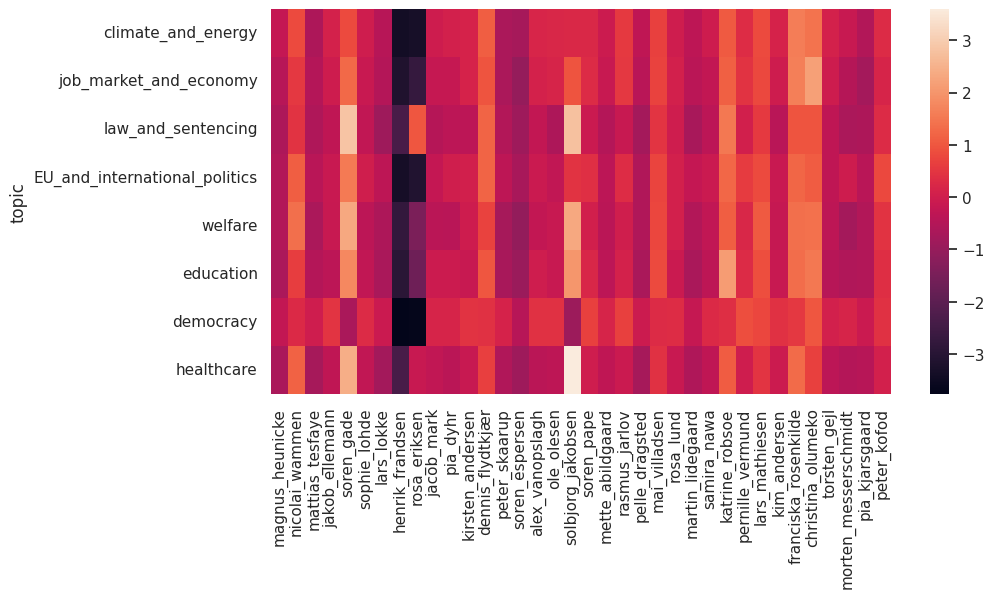

In [ ]:
df_similarity = pd.DataFrame(columns=df_topic.topic)
for i in range(len(df_politician)):
    for j in range(len(df_topic)):
        df_similarity.loc[df_politician.Person[i],df_topic.topic[j]] = jaccard_similarity(df_politician.Tweets[i], df_topic.text[j])

df_similarity.fillna(0, inplace=True)

df_similarity_norm = (df_similarity-df_similarity.min(axis=0))/(df_similarity.max(axis=0)-df_similarity.min(axis=0))
df_similarity_std = (df_similarity-df_similarity.mean(axis=0))/df_similarity.std(axis=0)

fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(df_similarity_std.T, ax = ax)

### Similarity between subjects and parties

<AxesSubplot: ylabel='topic'>

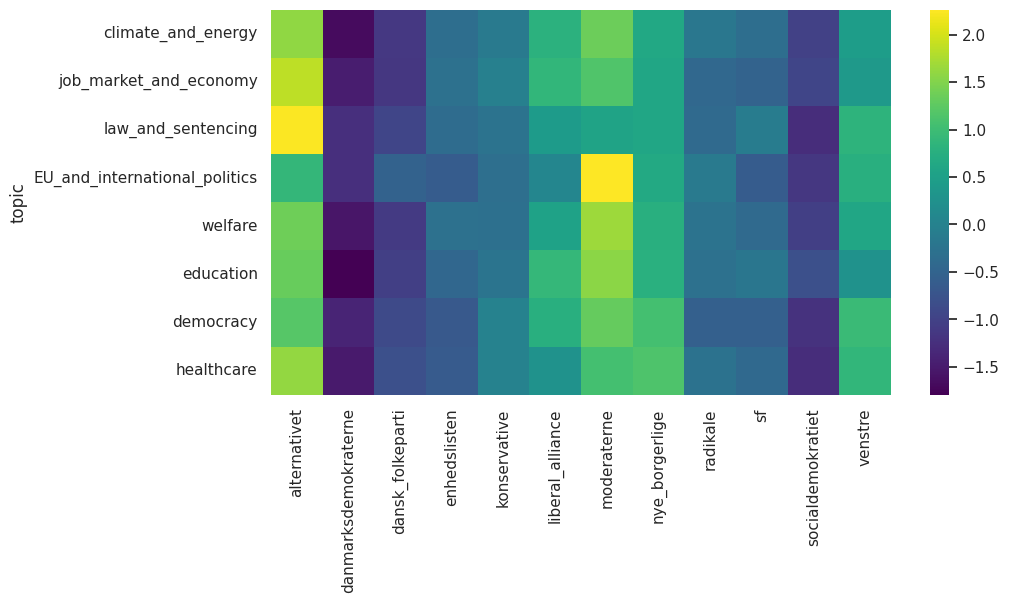

In [ ]:
df_similarity = pd.DataFrame(columns=df_topic.topic)
df_party = df_politician.groupby("Party").sum()
for i in range(len(df_party)):
    for j in range(len(df_topic)):
        df_similarity.loc[df_party.index[i],df_topic.topic[j]] = jaccard_similarity(df_party.Tweets[i], df_topic.text[j])

df_similarity.fillna(0, inplace=True)
df_similarity_norm = (df_similarity-df_similarity.min(axis=0))/(df_similarity.max(axis=0)-df_similarity.min(axis=0))
df_similarity_std = (df_similarity-df_similarity.mean(axis=0))/df_similarity.std(axis=0)

fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(df_similarity_std.T, ax = ax, cmap="viridis")

In [ ]:
df_politician.groupby("Party").sum().index

Index(['alternativet', 'danmarksdemokraterne', 'dansk_folkeparti',
       'enhedslisten', 'konservative', 'liberal_alliance', 'moderaterne',
       'nye_borgerlige', 'radikale', 'sf', 'socialdemokratiet', 'venstre'],
      dtype='object', name='Party')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30797f9c-952e-45b4-98d4-31c9ac73ae78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>